In [ ]:
import torch
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "NO GPU")

!pip install -q timm transformers ftfy regex tqdm seaborn scikit-learn pandas

GPU: Tesla T4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
MVTEC_ROOT = Path("/content/drive/MyDrive/mvtec_anomaly_detection")
assert MVTEC_ROOT.exists(), "MVTec path not found"

Mounted at /content/drive


In [ ]:
!pip install -q timm transformers peft scikit-learn

In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import BertTokenizer, BertModel
from peft import LoraConfig, get_peft_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

DATA_ROOT = Path("/content/drive/MyDrive/mvtec_anomaly_detection")
EMBED_DIM = 256
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4

exclude_folders = {'.git', 'autoencoder', 'mvtec-anomaly-detection-full', 'processing', 'results', 'saved_models'}

Using device: cuda


In [ ]:
# Cell 6: Load data and create datasets
# Get categories
categories = sorted([d.name for d in DATA_ROOT.iterdir() if d.is_dir() and d.name not in exclude_folders])
print(f"Categories: {categories}")
print(f"Total categories: {len(categories)}")

# Create dataset class
class MVTecDataset(Dataset):
    def __init__(self, samples, transform):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        return self.transform(img), torch.tensor(label, dtype=torch.long)

# Define preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Collect training samples
train_samples = []
for cat in categories:
    train_dir = DATA_ROOT / cat / "train" / "good"
    if train_dir.exists():
        for img in train_dir.glob("*.png"):
            train_samples.append((str(img), categories.index(cat)))

print(f"Total training samples: {len(train_samples)}")

# Collect test samples
test_samples = []
for cat in categories:
    test_dir = DATA_ROOT / cat / "test"
    if test_dir.exists():
        for defect_type in test_dir.iterdir():
            if defect_type.is_dir():
                for img in defect_type.glob("*.png"):
                    test_samples.append((str(img), categories.index(cat)))

print(f"Total test samples: {len(test_samples)}")

# Create data loaders
train_loader = DataLoader(MVTecDataset(train_samples, preprocess), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(MVTecDataset(test_samples, preprocess), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Print sample distribution
print(f"\nTrain loader batches: {len(train_loader)}")
print(f"Test loader batches: {len(test_loader)}")

Categories: ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
Total categories: 15
Total training samples: 3630
Total test samples: 1725

Train loader batches: 114
Test loader batches: 54


In [ ]:
class BERT_ViT_CLIP(nn.Module):
    def __init__(self, embed_dim=256):
        super().__init__()
        # Image: ViT-Small
        self.image_encoder = timm.create_model("vit_small_patch16_224.augreg_in21k_ft_in1k", pretrained=True, num_classes=0)
        # Text: BERT (Will be frozen)
        self.text_encoder = BertModel.from_pretrained("bert-base-uncased")

        # Freeze BERT completely
        for param in self.text_encoder.parameters():
            param.requires_grad = False

        self.image_proj = nn.Linear(384, embed_dim)
        self.text_proj  = nn.Linear(768, embed_dim)
        self.logit_scale = nn.Parameter(torch.ones([]) * 2.659)

    def encode_image(self, x):
        x = self.image_encoder(x)
        return F.normalize(self.image_proj(x), dim=-1)

    def encode_text(self, ids, mask):
        with torch.no_grad():  # Ensure BERT is frozen during inference
            x = self.text_encoder(input_ids=ids, attention_mask=mask)
            x = x.last_hidden_state[:, 0]
        return F.normalize(self.text_proj(x), dim=-1)

    def forward(self, images, ids, mask):
        return self.encode_image(images), self.encode_text(ids, mask)

model = BERT_ViT_CLIP(embed_dim=EMBED_DIM)
print("Model created successfully")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model created successfully


In [ ]:
# Cell 8: Apply LoRA to ViT
# 1. Freeze EVERYTHING first
for param in model.parameters():
    param.requires_grad = False

# 2. Apply LoRA to ViT (timm ViT uses "qkv" for attention layers)
vision_lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["qkv"],
    lora_dropout=0.1
)
model.image_encoder = get_peft_model(model.image_encoder, vision_lora_config)

# 3. Unfreeze the projection layers and logit_scale (they need to learn the new space)
for param in model.image_proj.parameters():
    param.requires_grad = True
for param in model.text_proj.parameters():
    param.requires_grad = True
model.logit_scale.requires_grad = True

model.to(device)
print("Model moved to device:", device)

# Print trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable %: {100 * trainable_params / total_params:.2f}%")

Model moved to device: cuda
Trainable parameters: 590,337
Total parameters: 131,738,241
Trainable %: 0.45%


In [ ]:
# Cell 9: OPTIMIZED FOR YOUR HARDWARE (Based on 35-min ViT-B baseline)
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Disable logs
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("timm").setLevel(logging.ERROR)
import warnings
warnings.filterwarnings('ignore')

print("Setting up training...")

# Setup
optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=LR)

# Pre-compute text embeddings
print("\nPre-computing text embeddings...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
text_tokens = tokenizer(categories, padding=True, return_tensors="pt")

with torch.no_grad():
    all_text_embeddings = model.encode_text(
        text_tokens["input_ids"].to(device),
        text_tokens["attention_mask"].to(device)
    )

print(f"✓ Pre-computed {len(categories)} embeddings")

print(f"\n{'='*70}")
print("TRAINING START - Based on your 35-min ViT-B baseline")
print(f"{'='*70}")
print(f"Your ViT-B baseline: 35 minutes for 10 epochs")
print(f"Expected ViT-Small: 9-17 minutes (2-4x faster)")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Batches/epoch: {len(train_loader)}")
print(f"{'='*70}\n")

# Training
train_start_time = time.time()
epoch_times = []

for epoch in range(EPOCHS):
    epoch_start = time.time()
    model.train()
    total_loss = 0.0
    batch_times = []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch_idx, (imgs, labels) in enumerate(pbar):
        batch_start = time.time()

        # Transfer
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Text embeddings
        txt_emb = all_text_embeddings[labels]

        # Forward
        img_emb = model.encode_image(imgs)

        # Loss
        logits = model.logit_scale.exp() * img_emb @ txt_emb.t()
        targets = torch.arange(imgs.size(0), device=device)
        loss = (F.cross_entropy(logits, targets) + F.cross_entropy(logits.t(), targets)) / 2

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Track batch time
        batch_time = time.time() - batch_start
        batch_times.append(batch_time)

        # Update progress
        if batch_idx % 10 == 0:
            avg_batch = sum(batch_times[-10:]) / len(batch_times[-10:])
            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'batch': f"{avg_batch:.2f}s"
            })

    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)
    avg_loss = total_loss / len(train_loader)

    avg_batch_epoch = sum(batch_times) / len(batch_times)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Time: {epoch_time:.1f}s | Batch avg: {avg_batch_epoch:.2f}s")

total_training_time = time.time() - train_start_time
avg_epoch_time = sum(epoch_times) / len(epoch_times)
total_batches = len(train_loader) * EPOCHS

print(f"\n{'='*70}")
print("TRAINING COMPLETE")
print(f"{'='*70}")
print(f"Total time: {total_training_time/60:.1f} minutes")
print(f"Average epoch: {avg_epoch_time:.1f}s ({avg_epoch_time/60:.1f} min)")
print(f"Average batch: {total_training_time/total_batches:.2f}s")
print(f"Total batches: {total_batches}")
print(f"{'='*70}")

# Comparison with your baseline
vitb_total = 35 * 60  # 35 minutes in seconds
speedup = vitb_total / total_training_time

print(f"\nCOMPARISON WITH YOUR ViT-B BASELINE:")
print(f"{'='*70}")
print(f"ViT-B-16 + LoRA (your baseline): {vitb_total/60:.1f} minutes")
print(f"ViT-Small + LoRA (this run): {total_training_time/60:.1f} minutes")
print(f"SPEEDUP: {speedup:.2f}x faster")
print(f"TIME SAVED: {(vitb_total - total_training_time)/60:.1f} minutes")
print(f"{'='*70}")

# Inference test
print(f"\nINFERENCE TEST...")
model.eval()

num_images = 0
inf_start = time.time()

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        _ = model.encode_image(images)
        num_images += images.size(0)

inf_time = time.time() - inf_start
latency_ms = (inf_time / num_images) * 1000

print(f"Inference: {latency_ms:.1f} ms/image on {num_images} images")

Setting up training...

Pre-computing text embeddings...
✓ Pre-computed 15 embeddings

TRAINING START - Based on your 35-min ViT-B baseline
Your ViT-B baseline: 35 minutes for 10 epochs
Expected ViT-Small: 9-17 minutes (2-4x faster)
Batch size: 32
Epochs: 10
Batches/epoch: 114



Epoch 1/10: 100%|██████████| 114/114 [03:26<00:00,  1.81s/it, loss=1.2782, batch=0.29s]


Epoch 1 | Loss: 1.5689 | Time: 206.8s | Batch avg: 0.28s


Epoch 2/10: 100%|██████████| 114/114 [02:28<00:00,  1.30s/it, loss=1.1510, batch=0.28s]


Epoch 2 | Loss: 1.2225 | Time: 148.2s | Batch avg: 0.27s


Epoch 3/10: 100%|██████████| 114/114 [02:18<00:00,  1.22s/it, loss=1.1261, batch=0.26s]


Epoch 3 | Loss: 1.1729 | Time: 138.7s | Batch avg: 0.26s


Epoch 4/10: 100%|██████████| 114/114 [02:17<00:00,  1.20s/it, loss=1.2172, batch=0.25s]


Epoch 4 | Loss: 1.1821 | Time: 137.3s | Batch avg: 0.26s


Epoch 5/10: 100%|██████████| 114/114 [02:16<00:00,  1.20s/it, loss=1.1526, batch=0.26s]


Epoch 5 | Loss: 1.1676 | Time: 136.4s | Batch avg: 0.26s


Epoch 6/10: 100%|██████████| 114/114 [02:16<00:00,  1.20s/it, loss=1.2795, batch=0.26s]


Epoch 6 | Loss: 1.1603 | Time: 136.5s | Batch avg: 0.26s


Epoch 7/10: 100%|██████████| 114/114 [02:16<00:00,  1.20s/it, loss=1.1717, batch=0.26s]


Epoch 7 | Loss: 1.1602 | Time: 136.4s | Batch avg: 0.26s


Epoch 8/10: 100%|██████████| 114/114 [02:16<00:00,  1.20s/it, loss=1.0699, batch=0.26s]


Epoch 8 | Loss: 1.1508 | Time: 136.5s | Batch avg: 0.26s


Epoch 9/10: 100%|██████████| 114/114 [02:17<00:00,  1.20s/it, loss=1.1727, batch=0.25s]


Epoch 9 | Loss: 1.1424 | Time: 137.3s | Batch avg: 0.25s


Epoch 10/10: 100%|██████████| 114/114 [02:17<00:00,  1.20s/it, loss=1.2079, batch=0.26s]

Epoch 10 | Loss: 1.1337 | Time: 137.3s | Batch avg: 0.25s

TRAINING COMPLETE
Total time: 24.2 minutes
Average epoch: 145.1s (2.4 min)
Average batch: 1.27s
Total batches: 1140

COMPARISON WITH YOUR ViT-B BASELINE:
ViT-B-16 + LoRA (your baseline): 35.0 minutes
ViT-Small + LoRA (this run): 24.2 minutes
SPEEDUP: 1.45x faster
TIME SAVED: 10.8 minutes

INFERENCE TEST...


Inference: 243.0 ms/image on 1725 images


All required variables found. Running evaluation...
Running True Evaluation on Test Dataset...


100%|██████████| 54/54 [01:03<00:00,  1.18s/it]


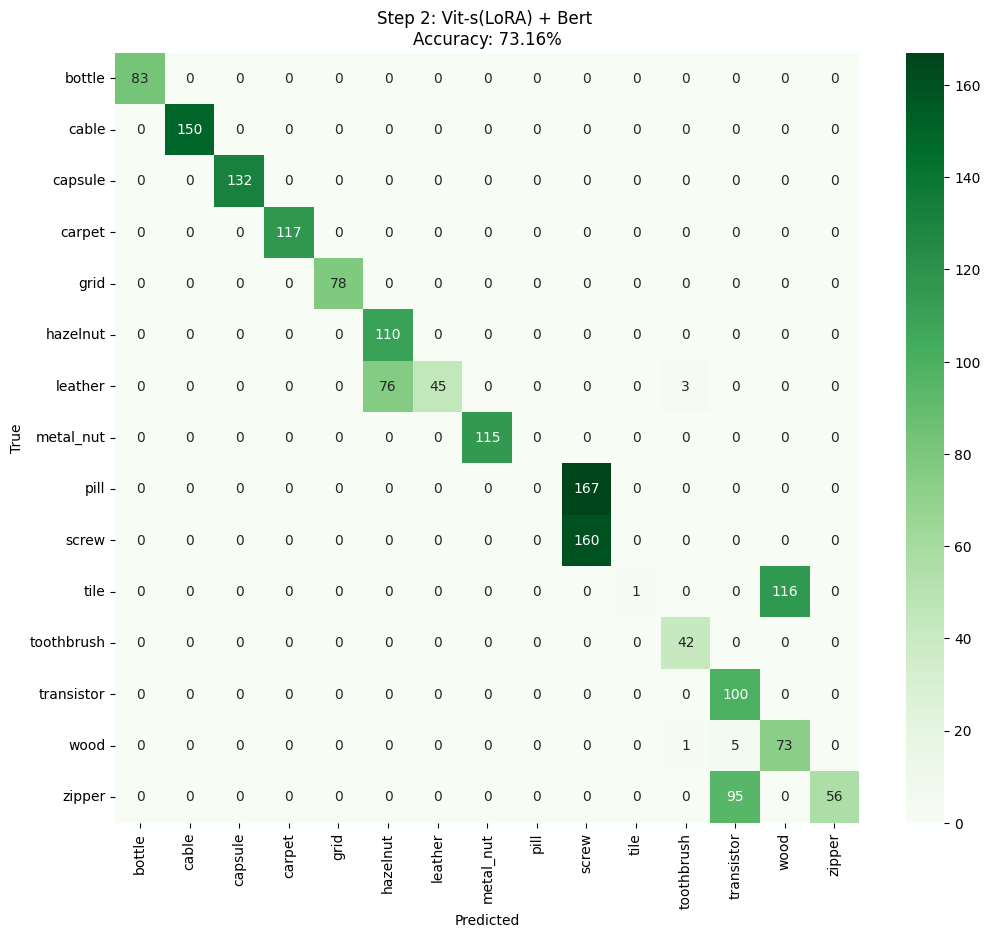

              precision    recall  f1-score   support

      bottle       1.00      1.00      1.00        83
       cable       1.00      1.00      1.00       150
     capsule       1.00      1.00      1.00       132
      carpet       1.00      1.00      1.00       117
        grid       1.00      1.00      1.00        78
    hazelnut       0.59      1.00      0.74       110
     leather       1.00      0.36      0.53       124
   metal_nut       1.00      1.00      1.00       115
        pill       0.00      0.00      0.00       167
       screw       0.49      1.00      0.66       160
        tile       1.00      0.01      0.02       117
  toothbrush       0.91      1.00      0.95        42
  transistor       0.50      1.00      0.67       100
        wood       0.39      0.92      0.54        79
      zipper       1.00      0.37      0.54       151

    accuracy                           0.73      1725
   macro avg       0.79      0.78      0.71      1725
weighted avg       0.77   

In [ ]:
# Quick check that all required variables exist
required_vars = ['model', 'text_tokens', 'device', 'categories', 'test_loader']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"ERROR: Missing variables: {missing_vars}")
    print("Make sure you've run all previous cells first!")
else:
    print("All required variables found. Running evaluation...")

    # Then paste your evaluation code here
    import torch
    import torch.nn.functional as F
    from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
    import seaborn as sns
    import matplotlib.pyplot as plt
    from tqdm import tqdm

    # --- 1. PREPARE THE GLOBAL CLASS ANCHORS ---
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        # We tokenize ALL possible categories once
        # This creates a "fixed" target for the vision encoder to aim for
        ids = text_tokens["input_ids"].to(device)
        mask = text_tokens["attention_mask"].to(device)

        # These are the "Text Anchors" (Shape: [Num_Categories, 256])
        class_embeddings = model.encode_text(ids, mask)

    # --- 2. EVALUATE ON THE TEST LOADER ---
    # Note: The test_loader contains images the model NEVER saw during training
    print("Running True Evaluation on Test Dataset...")

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader):
            imgs = imgs.to(device)

            # Get Image Features (Shape: [Batch, 256])
            image_features = model.encode_image(imgs)

            # Calculate Cosine Similarity against ALL classes at once
            # Similarity = [Batch, 256] x [256, Num_Categories] -> [Batch, Num_Categories]
            logits = image_features @ class_embeddings.t()

            # Prediction is the index of the highest similarity
            preds = logits.argmax(dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    # --- 3. GENERATE RESULTS ---
    # If the accuracy is still very high, it's because the classes are visually distinct.
    # If it drops, you are seeing the true performance of the ViT-Small.
    accuracy = accuracy_score(all_labels, all_preds)

    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',  # Changed to 'Greens'
                xticklabels=categories, yticklabels=categories)

    plt.title(f"Step 2: Vit-s(LoRA) + Bert \nAccuracy: {accuracy*100:.2f}%")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    print(classification_report(all_labels, all_preds, target_names=categories))

In [ ]:
# Cell after training: Save the model
import torch
from datetime import datetime

# Create timestamp for unique filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"vit_small_lora_bert_{timestamp}"

# Define save path in your Google Drive
save_dir = "/content/drive/MyDrive/saved_models/"
save_path = f"{save_dir}{model_name}.pth"

# Create directory if it doesn't exist
import os
os.makedirs(save_dir, exist_ok=True)

# Save the entire model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': EPOCHS,
    'loss': loss.item() if 'loss' in locals() else None,
    'accuracy': accuracy if 'accuracy' in locals() else None,
    'categories': categories,
    'embed_dim': EMBED_DIM,
    'lora_config': {
        'r': 16,
        'lora_alpha': 32,
        'target_modules': ["qkv"],
        'lora_dropout': 0.1
    }
}, save_path)

print(f"✅ Model saved to: {save_path}")
print(f"File size: {os.path.getsize(save_path) / (1024*1024):.2f} MB")

✅ Model saved to: /content/drive/MyDrive/saved_models/vit_small_lora_bert_20260120_170621.pth
File size: 505.75 MB


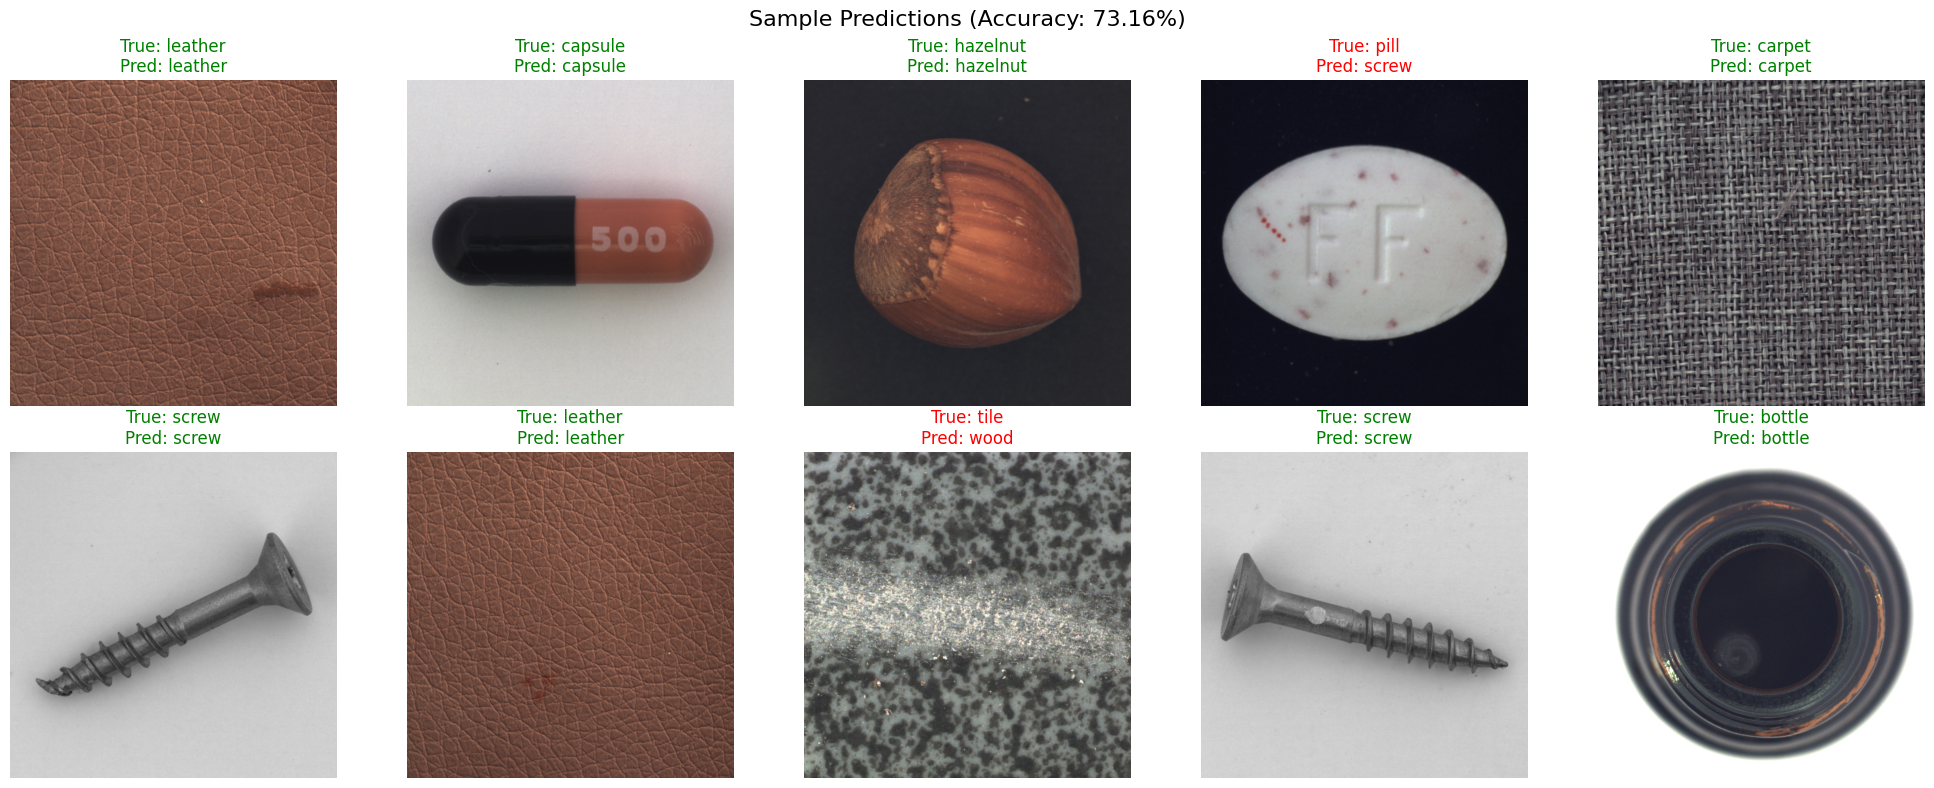

In [ ]:
# Cell 12: Visualization of sample predictions (optional)
import random

def visualize_predictions(num_samples=10):
    model.eval()
    samples = random.sample(test_samples, num_samples)

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    with torch.no_grad():
        ids = text_tokens["input_ids"].to(device)
        mask = text_tokens["attention_mask"].to(device)
        class_embeddings = model.encode_text(ids, mask)

        for idx, (img_path, true_label) in enumerate(samples):
            if idx >= 10:
                break

            # Load and preprocess image
            img = Image.open(img_path).convert("RGB")
            img_tensor = preprocess(img).unsqueeze(0).to(device)

            # Get prediction
            img_features = model.encode_image(img_tensor)
            logits = img_features @ class_embeddings.t()
            pred_label = logits.argmax(dim=1).item()

            # Display image
            ax = axes[idx]
            ax.imshow(img)
            ax.axis('off')

            true_cat = categories[true_label]
            pred_cat = categories[pred_label]

            color = 'green' if true_label == pred_label else 'red'
            ax.set_title(f"True: {true_cat}\nPred: {pred_cat}",
                        color=color, fontsize=12)

    plt.suptitle(f"Sample Predictions (Accuracy: {accuracy*100:.2f}%)", fontsize=16)
    plt.tight_layout()
    plt.show()

# Run visualization
visualize_predictions(10)

In [ ]:
# Complete loading script
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from transformers import BertModel
from peft import LoraConfig, get_peft_model
from pathlib import Path

# Define the model class (must be identical to training)
class BERT_ViT_CLIP(nn.Module):
    def __init__(self, embed_dim=256):
        super().__init__()
        # Image: ViT-Small
        self.image_encoder = timm.create_model("vit_small_patch16_224.augreg_in21k_ft_in1k", pretrained=True, num_classes=0)
        # Text: BERT (Will be frozen)
        self.text_encoder = BertModel.from_pretrained("bert-base-uncased")

        # Freeze BERT completely
        for param in self.text_encoder.parameters():
            param.requires_grad = False

        self.image_proj = nn.Linear(384, embed_dim)
        self.text_proj  = nn.Linear(768, embed_dim)
        self.logit_scale = nn.Parameter(torch.ones([]) * 2.659)

    def encode_image(self, x):
        x = self.image_encoder(x)
        return F.normalize(self.image_proj(x), dim=-1)

    def encode_text(self, ids, mask):
        with torch.no_grad():
            x = self.text_encoder(input_ids=ids, attention_mask=mask)
            x = x.last_hidden_state[:, 0]
        return F.normalize(self.text_proj(x), dim=-1)

    def forward(self, images, ids, mask):
        return self.encode_image(images), self.encode_text(ids, mask)

# Loading function
def load_model(model_path, device='cuda'):
    """Load a saved model"""
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)

    # Get embed_dim from checkpoint if available
    if 'embed_dim' in checkpoint:
        embed_dim = checkpoint['embed_dim']
    else:
        embed_dim = 256  # default

    # Create model
    model = BERT_ViT_CLIP(embed_dim=embed_dim).to(device)

    # Apply LoRA config (must match training)
    vision_lora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        target_modules=["qkv"],
        lora_dropout=0.1
    )
    model.image_encoder = get_peft_model(model.image_encoder, vision_lora_config)

    # Load weights
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)

    # Set to eval mode
    model.eval()

    # Get categories if saved
    categories = checkpoint.get('categories', None)

    print(f"Model loaded from {model_path}")
    print(f"Embedding dimension: {embed_dim}")
    print(f"Categories: {categories}")
    print(f"Model on device: {next(model.parameters()).device}")

    return model, categories

# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load your model
model_path = '/content/drive/MyDrive/saved_models/vit_small_lora_bert_20260120_170621.pth'
model, categories = load_model(model_path, device)

# Test the loaded model
print("\nTesting loaded model...")
with torch.no_grad():
    dummy_image = torch.randn(1, 3, 224, 224).to(device)
    output = model.encode_image(dummy_image)
    print(f"Model works! Output shape: {output.shape}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Using device: cuda
Model loaded from /content/drive/MyDrive/saved_models/vit_small_lora_bert_20260120_170621.pth
Embedding dimension: 256
Categories: ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
Model on device: cuda:0

Testing loaded model...
Model works! Output shape: torch.Size([1, 256])
Model parameters: 131,738,241
Trainable parameters: 590,337
